## Words Embeddings using GENSIM and word2vec

In [2]:
import re, gensim, logging, multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

__paths to change__

In [3]:
dataset_path = './datos/simpsons_dataset.csv'
results_path = './salida'

__packages config__

In [4]:
# congig
%matplotlib inline
sns.set_style("darkgrid")
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = multiprocessing.cpu_count()-1
border_size = 10

__process methods__

In [5]:
def expand_contractions(document: str) -> str:
    """
    Replace all abbreviations with their corresponding expansion
    """
    document = re.sub(r"'cause", "because", document)
    document = re.sub(r"o'clock", "of the clock", document)
    document = re.sub(r"won\'t", "will not", document)
    document = re.sub(r"can\'t", "can not", document)
    document = re.sub(r"n\'t", " not", document)
    document = re.sub(r"\'re", " are", document)
    document = re.sub(r"\'s", " is", document)
    document = re.sub(r"\'d", " would", document)
    document = re.sub(r"\'ll", " will", document)
    document = re.sub(r"\'t", " not", document)
    document = re.sub(r"\'ve", " have", document)
    document = re.sub(r"\'m", " am", document)
    return document

In [6]:
def replace_numbers(document: str) -> str:
    """
    Replace number appearances with 'number'
    """
    # Case 1: Combination of numbers and letters (Eg. 2nd -> NUM)
    document = re.sub('[a-zA-Z]+[0-9]+[a-zA-Z]+', 'number', document)
    document = re.sub('[0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+', 'number', document)
    # Case 2: Decimal numbers (Eg. 2.1 -> NUM)
    document = re.sub('[0-9]+\.+[0-9]+', 'number', document)
    # Case 3: Numbers between spaces (Eg. 220 888 -> NUM)
    document = re.sub('([0-9]+\s)*[0-9]+', 'number', document)
    # Case 4: One or more of the previous cases (Eg. NUM NUM -> NUM)
    document = re.sub('((NUM)+\s)*(NUM)+', 'number', document)
    return document

In [7]:
def preprocessing(document: str) -> list:
    """
    iterate over all words in document identifing the word and frecuency
    remove all the problematic characters over the word
    and return a dictionary with the word as the key and the frecuency as the value
    """
    document = document.lower()
    document = expand_contractions(document)
    document = replace_numbers(document)
    document = re.sub('[^A-Za-z]+', ' ', document)
    document = document.split()
    return document

In [8]:
def get_sentences(path: str) -> pd.DataFrame:
    """
    read and process document
    """
    sentences = pd.read_csv(path)
    sentences = sentences.dropna()
    sentences = sentences.drop_duplicates()
    sentences = sentences.reset_index(drop=True)
    sentences['processed'] = sentences.spoken_words.apply(preprocessing)
    return sentences

In [9]:
def train_model(size: int, window: int, data: list) -> gensim.models.Word2Vec:
    model = gensim.models.Word2Vec(sentences=data, vector_size=size, window=window, workers=workers, 
                                   min_count=3, alpha=0.025, min_alpha=0.0007)
    model.build_vocab(data, progress_per=10000)
    model.train(data, total_examples=len(data),epochs=10)
    return model

__train models__

In [10]:
sentences = get_sentences('./datos/simpsons_dataset.csv')
sentences.sample(10)

,raw_character_text,spoken_words,processed
1965,Bart Simpson,Twins. Open your present.,"[twins, open, your, present]"
77786,Grampa Simpson,You're the only smile I got.,"[you, are, the, only, smile, i, got]"
32049,Frank Grimes,"Stop laughing, you imbecile! Don't you realize...","[stop, laughing, you, imbecile, do, not, you, ..."
66212,Krusty the Clown,Let's see... champagne or Slim Fast?,"[let, is, see, champagne, or, slim, fast]"
107813,Seymour Skinner,So you know what osmosis is!,"[so, you, know, what, osmosis, is]"
112829,Homer Simpson,Not Marmaduke! Never Marmaduke!,"[not, marmaduke, never, marmaduke]"
22669,Bart Simpson,I sold my soul to Milhouse.,"[i, sold, my, soul, to, milhouse]"
63853,Waylon Smithers,"Hello, Simpson.","[hello, simpson]"
60652,Otto Mann,Pukers in back!,"[pukers, in, back]"
40828,Minister,"And do you, Homer, take this cocktail waitress...","[and, do, you, homer, take, this, cocktail, wa..."


In [11]:
#Train models
model_50 = train_model(50, 3, list(sentences.processed)) # vector size=50, window=3
model_100 = train_model(100, 3, list(sentences.processed)) # vector size=100, window=3
model_200 = train_model(200, 3, list(sentences.processed)) # vector size=200, window=3
#Save models
model_50.save(f'{results_path}/Simpsons_50_02.model')
model_100.save(f'{results_path}/Simpsons_100_02.model')
model_200.save(f'{results_path}/Simpsons_200_02.model')

2022-07-12 11:30:02,260 : INFO : collecting all words and their counts
2022-07-12 11:30:02,261 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-12 11:30:02,275 : INFO : PROGRESS: at sentence #10000, processed 105455 words, keeping 9465 word types
2022-07-12 11:30:02,289 : INFO : PROGRESS: at sentence #20000, processed 216675 words, keeping 14477 word types
2022-07-12 11:30:02,303 : INFO : PROGRESS: at sentence #30000, processed 335425 words, keeping 18685 word types
2022-07-12 11:30:02,318 : INFO : PROGRESS: at sentence #40000, processed 444038 words, keeping 21421 word types
2022-07-12 11:30:02,333 : INFO : PROGRESS: at sentence #50000, processed 545921 words, keeping 24015 word types
2022-07-12 11:30:02,346 : INFO : PROGRESS: at sentence #60000, processed 640215 words, keeping 26169 word types
2022-07-12 11:30:02,361 : INFO : PROGRESS: at sentence #70000, processed 749304 words, keeping 28453 word types
2022-07-12 11:30:02,376 : INFO : PROGRESS: at s

In [12]:
#Load models
model_50 = gensim.models.Word2Vec.load(f'{results_path}/Simpsons_50_02.model')
model_100 = gensim.models.Word2Vec.load(f'{results_path}/Simpsons_100_02.model')
model_200 = gensim.models.Word2Vec.load(f'{results_path}/Simpsons_200_02.model')

2022-07-12 11:30:32,485 : INFO : loading Word2Vec object from ./salida/Simpsons_50_02.model
2022-07-12 11:30:32,502 : INFO : loading wv recursively from ./salida/Simpsons_50_02.model.wv.* with mmap=None
2022-07-12 11:30:32,503 : INFO : setting ignored attribute cum_table to None
2022-07-12 11:30:32,667 : INFO : Word2Vec lifecycle event {'fname': './salida/Simpsons_50_02.model', 'datetime': '2022-07-12T11:30:32.667358', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}
2022-07-12 11:30:32,669 : INFO : loading Word2Vec object from ./salida/Simpsons_100_02.model
2022-07-12 11:30:32,689 : INFO : loading wv recursively from ./salida/Simpsons_100_02.model.wv.* with mmap=None
2022-07-12 11:30:32,690 : INFO : setting ignored attribute cum_table to None
2022-07-12 11:30:32,819 : INFO : Word2Vec lifecycle event {'fname': './salida/Simpsons_100_02.model', 'datetime': '2022-07

In [13]:
model_50.wv.most_similar(positive=["california", "texas", "florida"], topn=10)

[('arena', 0.9278457164764404),
 ('tennessee', 0.9267467856407166),
 ('conjunction', 0.9260543584823608),
 ('daycare', 0.9256625175476074),
 ('institute', 0.9192383885383606),
 ('fiber', 0.9157180786132812),
 ('dome', 0.9141632914543152),
 ('scale', 0.9140186309814453),
 ('excellence', 0.9137997627258301),
 ('hydro', 0.9128237366676331)]

In [14]:
model_100.wv.most_similar(positive=["california", "texas", "florida"], topn=10)

[('neptune', 0.8901838064193726),
 ('scalpel', 0.8883477449417114),
 ('cesspool', 0.887711763381958),
 ('lavender', 0.8876796960830688),
 ('linen', 0.8844446539878845),
 ('soviet', 0.8841024041175842),
 ('beatle', 0.8839977383613586),
 ('humidor', 0.8839464783668518),
 ('hansen', 0.8835275769233704),
 ('plots', 0.8829852938652039)]

In [15]:
model_200.wv.most_similar(positive=["california", "texas", "florida"], topn=10)

[('soviet', 0.8890364766120911),
 ('montreal', 0.8852013349533081),
 ('germany', 0.8804223537445068),
 ('excellence', 0.8715123534202576),
 ('tennessee', 0.869774341583252),
 ('fiendish', 0.8688960075378418),
 ('homo', 0.8615266680717468),
 ('ernest', 0.8606977462768555),
 ('tidal', 0.8595371842384338),
 ('dome', 0.8584707975387573)]

## _plotting embeddings in two dimentions_

In [16]:
def tsnescatterplot(model: gensim.models.word2vec.Word2Vec, word_list: list):
    """ 
    Plot in seaborn the results from the t-SNE dimensionality reduction algorithm 
    of the vectors of a query words
    """
    arrays = np.empty((0, model.wv.vector_size), dtype='f')
    words, colors, similar = [], [], []

    # adds the vector for each of the words from word_list to the array
    for wrd in word_list:
        wrd_vector = model.wv.__getitem__([wrd])
        words.append(wrd)
        colors.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        similar = similar + model.wv.most_similar([wrd], topn=20)

    # adds the vector for each of the closest words to the array
    for close_wrd in similar:
        if close_wrd[0] not in words:# and len(words) < 20:
            wrd_vector = model.wv.__getitem__([close_wrd[0]])
            words.append(close_wrd[0])
            colors.append('blue')
            arrays = np.append(arrays, wrd_vector, axis=0)

    # Finds t-SNE coordinates for 2 dimensions
    euclidean = TSNE(init='random', learning_rate='auto', n_components=2, random_state=0, perplexity=30)
    euclidean = euclidean.fit_transform(arrays)

    # Sets everything up to plot
    x = [x for x in euclidean[:, 0]]
    y = [y for y in euclidean[:, 1]]
    df = pd.DataFrame({'x':x , 'y':y, 'words': words, 'color': colors})
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 8)

    # Basic plot
    plot = sns.regplot(data=df, x="x", y="y", fit_reg=False, marker="o", 
                       scatter_kws={'s':40, 'facecolors':df.color})

    # Adds annotations one by one
    for item in range(0, df.shape[0]):
        x_pos = df.x.get(item)
        y_pos = df.y.get(item)
        name = ' ' + df.words.get(item)
        color = df.color.get(item)
        plot.text(x_pos, y_pos, name, color=color, size='medium', weight='normal').set_size(12)

    plt.title(f't-SNE visualization')

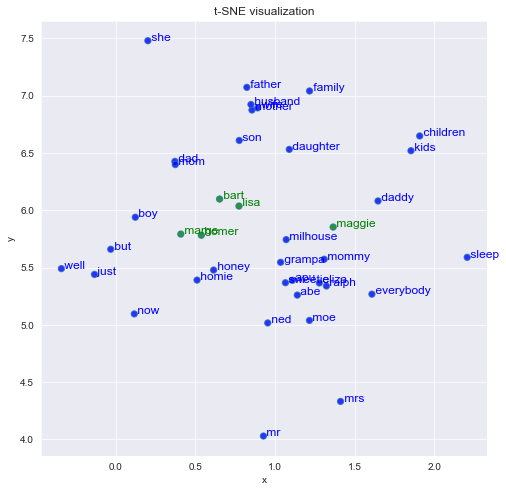

In [17]:
tsnescatterplot(model_50, ['bart', 'lisa', 'homer', 'marge', 'maggie'])

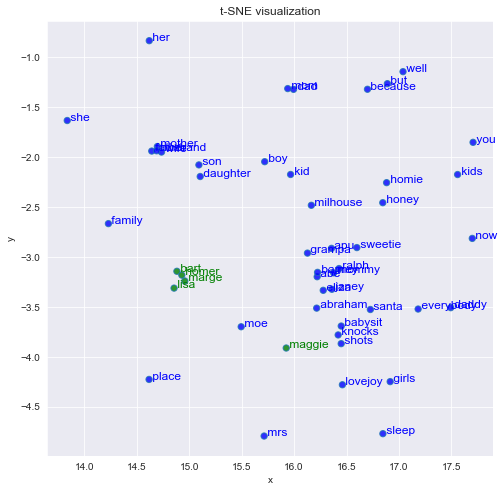

In [18]:
tsnescatterplot(model_100, ['bart', 'lisa', 'homer', 'marge', 'maggie'])

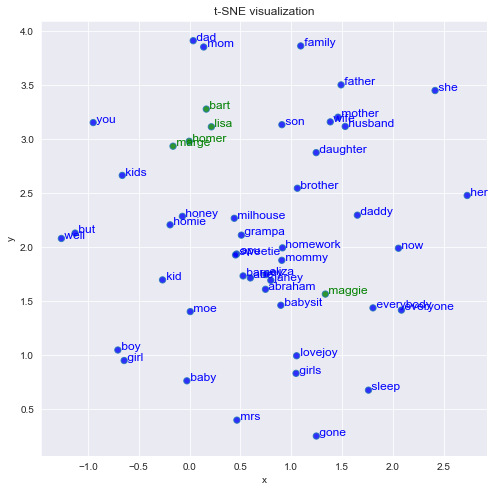

In [19]:
tsnescatterplot(model_200, ['bart', 'lisa', 'homer', 'marge', 'maggie'])

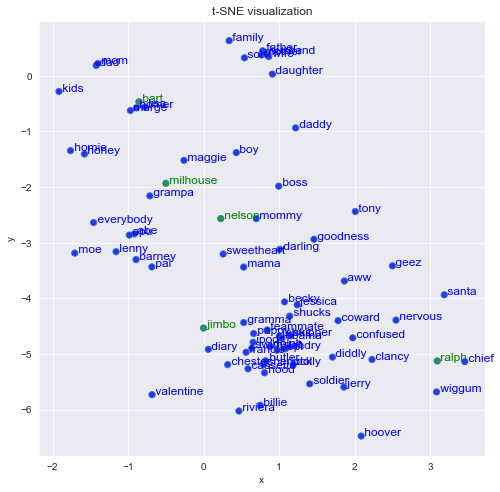

In [20]:
tsnescatterplot(model_50, ['bart', 'milhouse', 'nelson', 'jimbo', 'ralph'])

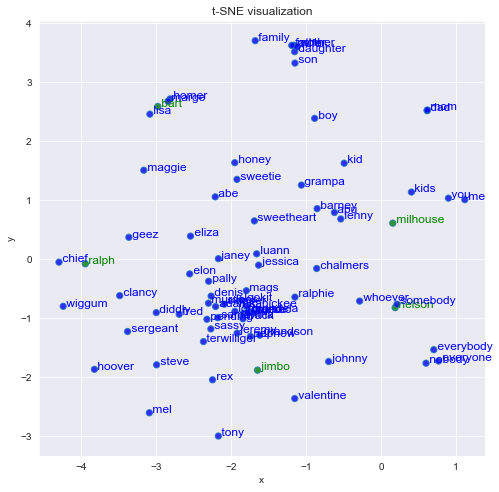

In [21]:
tsnescatterplot(model_100, ['bart', 'milhouse', 'nelson', 'jimbo', 'ralph'])

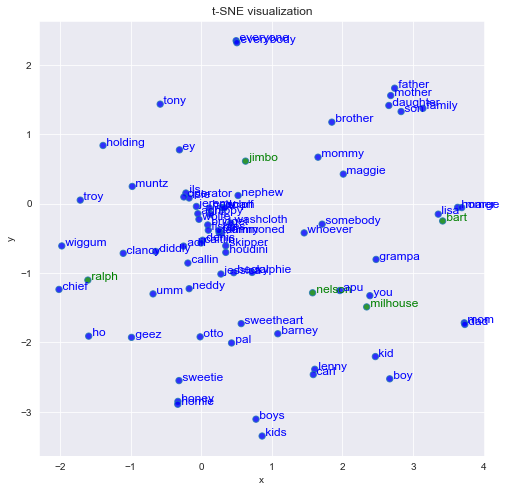

In [22]:
tsnescatterplot(model_200, ['bart', 'milhouse', 'nelson', 'jimbo', 'ralph'])